In [1]:
!python --version

Python 3.9.19


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from src.results_loaders import CLadder, ProntoQA, ngram_vectorize_new, select_features, HelmResultsLoader, EvalsResultsLoader
from src.classification_utils import _evaluate_predictive_method_from_arrays, evaluate_predictive_method
from src.utils import load_with_conditions, save_dataframe, Cohen_correction, initialize_instance
from src.readability_diversity_metrics import compute_diversity_and_readability_metrics
import numpy as np

from tqdm.notebook import tqdm
# filter warnings
import warnings
warnings.filterwarnings("ignore")

# enable reloading of modules
%load_ext autoreload
%autoreload 2

/home/lorenzo/venv/recog-LLM_capabilities/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package punkt to /home/lorenzo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Fit classifier using simple features to predict the ground truth  

List the various datasets from HELM and KindsOfReasoning and the datasets with specialised loaders.

In [6]:
helm_list = [('legalbench', 'abercrombie'), ('legalbench', 'corporate_lobbying'), ('legalbench', 'function_of_decision_section'), ('legalbench', 'proa'), ('legalbench', 'international_citizenship_questions')]

In [7]:
evals_list = ['fantasy_reasoning',
 'neubaroco',
 'moral_permissibility',
 'causal_judgment',
 'metaphor_boolean',
 'commonsense_qa_2',
 'space_nli',
 'anli',
 'art',
 'wanli',
 'babi_task_16',
 'formal_fallacies_syllogisms_negation']

In [10]:
total_list = [(EvalsResultsLoader, eval) for eval in evals_list] + [(HelmResultsLoader, scenario, subscenario) for scenario, subscenario in helm_list] + [(CLadder,), (ProntoQA,)]

### Now train classifiers using the n-grams.

In [12]:
def _check_skip(res_df, pred_method_name, feature_name, dataset_name):
    if len(res_df) > 0 and len(res_df[(res_df["predictive_method"] == pred_method_name) & (
            res_df["features"] == feature_name) & (res_df["dataset"] == dataset_name)]) > 0:
        print(f"Skipping {feature_name}, {pred_method_name} because it is already in the dataframe")
        return True
    else:
        print(f"Doing {feature_name}, {pred_method_name}")
        return False


def _concat_and_save(res_df, pred_method_name, feature_name, dataset_name, group,
                     Accuracy_val, Accuracy_test, instance_level_predictions_val, instance_level_predictions_test,
                     trained_method, filename):
    res_df = pd.concat([res_df, pd.DataFrame(
        [{"predictive_method": pred_method_name, "features": feature_name, "trained_classifier": trained_method,
          "Accuracy_val": Accuracy_val, "Accuracy_test": Accuracy_test,
          "instance_level_predictions_val": np.array(instance_level_predictions_val),
          "instance_level_predictions_test": np.array(instance_level_predictions_test),
          "dataset": dataset_name, "group": group}], index=[0])])

    save_dataframe(filename, res_df)
    return res_df


def evaluate_and_update(res_df, train_df, validation_df, test_df, features, predictive_method,
                        pred_method_name, feature_name, dataset_name, group,
                        filename, **kwargs):
    if not _check_skip(res_df, pred_method_name, feature_name):
        results = evaluate_predictive_method(train_df, test_df,
                                             features,
                                             f"ideal_encoded",
                                             predictive_method=predictive_method,
                                             return_instance_level_predictions=True,
                                             return_trained_method=True, binary=False,
                                             compute_accuracy=True,
                                             **kwargs)
        Accuracy_test, trained_method, instance_level_predictions_test = results["accuracy"], results[
            "method_instance"], \
            results["instance_level_predictions"]

        results = evaluate_predictive_method(train_df, validation_df,
                                             features,
                                             f"ideal_encoded",
                                             predictive_method=predictive_method,
                                             return_instance_level_predictions=True,
                                             trained_method=trained_method, binary=False, compute_accuracy=True,
                                             **kwargs)
        Accuracy_val, instance_level_predictions_val = results["accuracy"], results["instance_level_predictions"]

        res_df = _concat_and_save(res_df, pred_method_name, feature_name, dataset_name, group,
                                  Accuracy_val, Accuracy_test, instance_level_predictions_val,
                                  instance_level_predictions_test,
                                  trained_method, filename)
    return res_df


def evaluate_and_update_arrays(res_df, X_train, train_labels, X_val, val_labels,
                               X_test, test_labels, predictive_method,
                               pred_method_name, feature_name, dataset_name, group,
                               filename, **kwargs):
    if not _check_skip(res_df, pred_method_name, feature_name, dataset_name):
        results = _evaluate_predictive_method_from_arrays(X_train,
                                                          train_labels,
                                                          X_test,
                                                          test_labels,
                                                          predictive_method=predictive_method,
                                                          return_trained_method=True,
                                                          return_instance_level_predictions=True,
                                                          binary=False,
                                                          compute_accuracy=True,
                                                          **kwargs)

        Accuracy_test, trained_method, instance_level_predictions_test = results["accuracy"], results[
            "method_instance"], \
            results["instance_level_predictions"]

        results = _evaluate_predictive_method_from_arrays(X_train,
                                                          train_labels,
                                                          X_val,
                                                          val_labels,
                                                          predictive_method=predictive_method,
                                                          return_instance_level_predictions=True,
                                                          trained_method=trained_method, binary=False,
                                                          compute_accuracy=True,
                                                          **kwargs)
        Accuracy_val, instance_level_predictions_val = results["accuracy"], results["instance_level_predictions"]

        res_df = _concat_and_save(res_df, pred_method_name, feature_name, dataset_name, group,
                                  Accuracy_val, Accuracy_test, instance_level_predictions_val,
                                  instance_level_predictions_test,
                                  trained_method, filename)
    return res_df


def add_baselines(res_df, instance, ideal_col_name, train_df, val_df, test_df, dataset_name, group,
                  filename):
    # random guess:
    pred_method_name = "random_guess"
    feature_name = "random_guess"

    # count how many unique values there are in the ground truth
    n_choices = len(instance.results_df[ideal_col_name].unique())
    random_guess_accuracy = 1 / n_choices
    random_guess_instance_level_predictions_val = None
    random_guess_instance_level_predictions_test = None

    if not _check_skip(res_df, pred_method_name, feature_name, dataset_name):
        res_df = _concat_and_save(res_df, pred_method_name, feature_name, dataset_name, group,
                                  random_guess_accuracy, random_guess_accuracy,
                                  random_guess_instance_level_predictions_val,
                                  random_guess_instance_level_predictions_test,
                                  None, filename)

    # most likely option
    pred_method_name = "most_likely_answer"
    feature_name = "most_likely_answer"

    # now extract the most likely option in the train set
    most_likely_answer = train_df[ideal_col_name].value_counts().idxmax()
    most_likely_answer_instance_level_predictions_val = most_likely_answer
    most_likely_answer_instance_level_predictions_test = most_likely_answer
    most_likely_answer_accuracy_val = (val_df[ideal_col_name] == most_likely_answer).mean()
    most_likely_answer_accuracy_test = (test_df[ideal_col_name] == most_likely_answer).mean()

    if not _check_skip(res_df, pred_method_name, feature_name, dataset_name):
        res_df = _concat_and_save(res_df, pred_method_name, feature_name, dataset_name, group,
                                  most_likely_answer_accuracy_val, most_likely_answer_accuracy_test,
                                  most_likely_answer_instance_level_predictions_val,
                                  most_likely_answer_instance_level_predictions_test,
                                  None, filename)

    return res_df


def prepare_dataset(dataset, use_word2vec=False, use_fasttext=False, verbose=True):
    instance, dataset_name, ideal_col_name, group = initialize_instance(dataset)

    if use_word2vec:
        print("Extracting word2vec embeddings")
        instance.extract_simple_embeddings(skip_na_rows=False, embedding_model="word2vec", filter_stopwords=True)
        print("Done")
    if use_fasttext:
        print("Extracting fasttext embeddings")
        instance.extract_simple_embeddings(skip_na_rows=False, embedding_model="fasttext", filter_stopwords=True)
        print("Done")

    train_df, val_df, test_df = instance.train_val_test_split(discard_na_rows=False, rng=np.random.RandomState(42),
                                                              train_size=0.6, val_size=0.2)
    if verbose:
        print(f'{dataset_name} train_df shape: {train_df.shape}')
        print(f'{dataset_name} val_df shape: {val_df.shape}')
        print(f'{dataset_name} test_df shape: {test_df.shape}')

    primal_train_labels = train_df[ideal_col_name]
    primal_val_labels = val_df[ideal_col_name]
    primal_test_labels = test_df[ideal_col_name]

    # do the encoding of the labels (this is in principle not needed for the ones where the answer is binary)
    label_encoder = LabelEncoder()
    primal_train_labels_encoded = label_encoder.fit_transform(primal_train_labels)
    primal_val_labels_encoded = label_encoder.transform(primal_val_labels)
    primal_test_labels_encoded = label_encoder.transform(primal_test_labels)

    # add them to the column ideal_encoded
    train_df["ideal_encoded"] = primal_train_labels_encoded
    val_df["ideal_encoded"] = primal_val_labels_encoded
    test_df["ideal_encoded"] = primal_test_labels_encoded

    train_prompts = list(train_df["prompt"])
    val_prompts = list(val_df["prompt"])
    test_prompts = list(test_df["prompt"])

    return instance, dataset_name, ideal_col_name, group, train_df, val_df, test_df, train_prompts, val_prompts, test_prompts, primal_train_labels_encoded, primal_val_labels_encoded, primal_test_labels_encoded

Make a table with the various datasets and their sizes

In [9]:
dataset_sizes = []
dataset_names = []
number_of_choices = []

for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group, train_df, val_df, test_df, train_prompts, val_prompts, test_prompts, primal_train_labels_encoded, primal_val_labels_encoded, primal_test_labels_encoded = prepare_dataset(dataset, False, False, verbose=False)
    dataset_sizes.append(instance.results_df.shape[0])
    dataset_names.append(dataset_name)
    all_labels = len(set(list(primal_train_labels_encoded) +  list(primal_val_labels_encoded) + list(primal_test_labels_encoded)))
    number_of_choices.append(all_labels)
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [69]:
# make a dataframe
dataset_sizes_df = pd.DataFrame({"dataset": dataset_names, "size": dataset_sizes, "number_of_choices": number_of_choices})
# print to latex
print(dataset_sizes_df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                                       dataset &  size &  number\_of\_choices \\
\midrule
                             fantasy\_reasoning &   197 &                  2 \\
                                     neubaroco &   363 &                  3 \\
                          moral\_permissibility &   338 &                  2 \\
                               causal\_judgment &   184 &                  2 \\
                              metaphor\_boolean &   676 &                  2 \\
                              commonsense\_qa\_2 &  2537 &                  2 \\
                                     space\_nli &  1600 &                  3 \\
                                          anli &  3196 &                  3 \\
                                           art &   364 &                  2 \\
                                         wanli &  1000 &                  3 \\
                                  babi\_task\_16 &  1000 &                  4 \\
  

Now create/load the dataframe with the results. The code loads it if it exists and avoids re-computing the results already available.

In [11]:
filename = "results/ground_truth_prediction_performance.pkl"

In [12]:
overwrite_res = False

primal_performance_df = load_with_conditions(filename, overwrite_res)

Loading existing dataframe.


In [13]:
primal_performance_df.shape

(1026, 9)

Now train the various classifiers.

In [14]:
classifiers_list = [(LogisticRegression, {}, "logistic_regression_l2"), (LogisticRegression, {"penalty": "l1", "solver": "liblinear"}, "logistic_regression_l1_c=1"), (LogisticRegression, {"penalty": "l1", "solver": "liblinear", "C": 0.1}, "logistic_regression_l1_c=0.1"), (XGBClassifier, {}, "xgboost")]

First do the baselines and the readability metrics

In [24]:
use_readability_diversity_metrics = True

In [ ]:
for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group, train_df, val_df, test_df, train_prompts, val_prompts, test_prompts, primal_train_labels_encoded, primal_val_labels_encoded, primal_test_labels_encoded = prepare_dataset(dataset)

    if use_readability_diversity_metrics:
        train_metrics = compute_diversity_and_readability_metrics(train_prompts)
        val_metrics = compute_diversity_and_readability_metrics(val_prompts)
        test_metrics = compute_diversity_and_readability_metrics(test_prompts)

        X_train_metrics = pd.DataFrame(train_metrics).values
        X_val_metrics = pd.DataFrame(val_metrics).values
        X_test_metrics = pd.DataFrame(test_metrics).values

    # baselines:
    #  - most likely answer
    #  - random guess (= 1/n_choices)

    primal_performance_df = add_baselines(primal_performance_df, instance, ideal_col_name, train_df, val_df, test_df, dataset_name, group,
                filename)

    # now attempt the classification on the primal problem
    for predictive_method, kwargs, pred_method_name in classifiers_list:

        if use_readability_diversity_metrics:
            primal_performance_df = evaluate_and_update_arrays(primal_performance_df, X_train_metrics, primal_train_labels_encoded, X_val_metrics, primal_val_labels_encoded,
                                                       X_test_metrics, primal_test_labels_encoded, predictive_method,
                                                       pred_method_name, f"readability_diversity_metrics", dataset_name, group, filename,
                                                       **kwargs)


  0%|          | 0/36 [00:00<?, ?it/s]

fantasy_reasoning train_df shape: (118, 21)
fantasy_reasoning val_df shape: (40, 21)
fantasy_reasoning test_df shape: (39, 21)
Doing random_guess, random_guess
Doing most_likely_answer, most_likely_answer
Doing readability_diversity_metrics, logistic_regression_l2
Doing readability_diversity_metrics, logistic_regression_l1_c=1
Doing readability_diversity_metrics, logistic_regression_l1_c=0.1
Doing readability_diversity_metrics, xgboost
neubaroco train_df shape: (218, 21)
neubaroco val_df shape: (72, 21)
neubaroco test_df shape: (73, 21)
Doing random_guess, random_guess
Doing most_likely_answer, most_likely_answer
Doing readability_diversity_metrics, logistic_regression_l2
Doing readability_diversity_metrics, logistic_regression_l1_c=1
Doing readability_diversity_metrics, logistic_regression_l1_c=0.1
Doing readability_diversity_metrics, xgboost
moral_permissibility train_df shape: (203, 21)
moral_permissibility val_df shape: (68, 21)
moral_permissibility test_df shape: (67, 21)
Doing ra

Now with the ngrams

In [25]:
use_ngrams = True
use_ngrams_tokenizer = True
n_gram_metrics = ["simple_frequency", "tfidf", "presence"]

n_gram_sizes = [1, 2]

In [56]:
for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group, train_df, val_df, test_df, train_prompts, val_prompts, test_prompts, primal_train_labels_encoded, primal_val_labels_encoded, primal_test_labels_encoded = prepare_dataset(dataset)

    for n_gram_size in n_gram_sizes:
        for metric in n_gram_metrics:

            if use_ngrams:
                #  to do use the new function to extract ngrams as this does not have test data
                X_train_ngrams, X_val_ngrams, X_test_ngrams, vectorizer = ngram_vectorize_new(train_prompts, val_prompts, test_prompts, ngram_range=(1, n_gram_size), metric=metric)
                X_train_ngrams_selected, X_val_ngrams_selected, X_test_ngrams_selected, selector = select_features(X_train_ngrams, primal_train_labels_encoded, X_val_ngrams, X_test_ngrams)

            if use_ngrams_tokenizer:
                #  to do use the new function to extract ngrams as this does not have test data
                X_train_ngrams, X_val_ngrams, X_test_ngrams, vectorizer = ngram_vectorize_new(train_prompts, val_prompts, test_prompts, ngram_range=(1, n_gram_size), use_gpt2_tokeniser=True, metric=metric)
                X_train_ngrams_selected_tok, X_val_ngrams_selected_tok, X_test_ngrams_selected_tok, selector_tok = select_features(X_train_ngrams, primal_train_labels_encoded, X_val_ngrams, X_test_ngrams)


            # now attempt the classification on the primal problem
            for predictive_method, kwargs, pred_method_name in classifiers_list:
                # n-grams
                if use_ngrams:
                    primal_performance_df = evaluate_and_update_arrays(primal_performance_df, X_train_ngrams_selected, primal_train_labels_encoded, X_val_ngrams_selected, primal_val_labels_encoded,
                                                                       X_test_ngrams_selected, primal_test_labels_encoded, predictive_method,
                                                                       pred_method_name, f"{n_gram_size}-grams_{metric}", dataset_name, group, filename,
                                                                       **kwargs)

                # n-grams with tokenizer
                if use_ngrams_tokenizer:
                    primal_performance_df = evaluate_and_update_arrays(primal_performance_df, X_train_ngrams_selected_tok, primal_train_labels_encoded, X_val_ngrams_selected_tok, primal_val_labels_encoded,
                                                                       X_test_ngrams_selected_tok, primal_test_labels_encoded, predictive_method,
                                                                       pred_method_name, f"{n_gram_size}-grams_{metric}_gpt2", dataset_name, group, filename,
                                                                       **kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

legalbench_international_citizenship_questions train_df shape: (600, 94)
legalbench_international_citizenship_questions val_df shape: (200, 94)
legalbench_international_citizenship_questions test_df shape: (200, 94)
Doing 1-grams_simple_frequency, logistic_regression_l2
Doing 1-grams_simple_frequency_gpt2, logistic_regression_l2
Doing 1-grams_simple_frequency, logistic_regression_l1_c=1
Doing 1-grams_simple_frequency_gpt2, logistic_regression_l1_c=1
Doing 1-grams_simple_frequency, logistic_regression_l1_c=0.1
Doing 1-grams_simple_frequency_gpt2, logistic_regression_l1_c=0.1
Doing 1-grams_simple_frequency, xgboost
Doing 1-grams_simple_frequency_gpt2, xgboost
Doing 1-grams_tfidf, logistic_regression_l2
Doing 1-grams_tfidf_gpt2, logistic_regression_l2
Doing 1-grams_tfidf, logistic_regression_l1_c=1
Doing 1-grams_tfidf_gpt2, logistic_regression_l1_c=1
Doing 1-grams_tfidf, logistic_regression_l1_c=0.1
Doing 1-grams_tfidf_gpt2, logistic_regression_l1_c=0.1
Doing 1-grams_tfidf, xgboost
Doing 

Finally with embeddings

In [ ]:
use_word2vec = False
use_fasttext = False
use_embeddings = False

In [ ]:
for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group, train_df, val_df, test_df, train_prompts, val_prompts, test_prompts, primal_train_labels_encoded, primal_val_labels_encoded, primal_test_labels_encoded = prepare_dataset(dataset, use_word2vec, use_fasttext)
    # now attempt the classification on the primal problem
    for predictive_method, kwargs, pred_method_name in classifiers_list:

        # embeddings
        if use_embeddings:
            primal_performance_df = evaluate_and_update(primal_performance_df, train_df, val_df, test_df,
                                                        ["openai_embeddings_large"], predictive_method,
                                                        pred_method_name, "embeddings", dataset_name, group, filename,
                                                        **kwargs)
        # word2vec
        if use_word2vec:
            primal_performance_df = evaluate_and_update(primal_performance_df, train_df, val_df, test_df,
                                                        ["word2vec_embeddings"], predictive_method,
                                                        pred_method_name, "word2vec", dataset_name, group, filename,
                                                        **kwargs)

        # fasttext
        if use_fasttext:
            primal_performance_df = evaluate_and_update(primal_performance_df, train_df, val_df, test_df,
                                                        ["fasttext_embeddings"], predictive_method,
                                                        pred_method_name, "fasttext", dataset_name, group, filename,
                                                        **kwargs)


In [ ]:
primal_performance_df.shape

In [25]:
primal_performance_df.tail()

,predictive_method,features,trained_classifier,Accuracy_val,Accuracy_test,instance_level_predictions_val,instance_level_predictions_test,dataset,group
1021,logistic_regression_l1_c=1,2-grams_presence_gpt2,"LogisticRegression(penalty='l1', solver='libli...",0.571528,0.568750,[0 0 0 ... 0 0 1],[1 0 1 ... 1 0 0],ProntoQA,others
1022,logistic_regression_l1_c=0.1,2-grams_presence,"LogisticRegression(C=0.1, penalty='l1', solver...",0.572222,0.588194,[0 0 0 ... 1 1 1],[1 0 0 ... 0 1 1],ProntoQA,others
1023,logistic_regression_l1_c=0.1,2-grams_presence_gpt2,"LogisticRegression(C=0.1, penalty='l1', solver...",0.563194,0.561111,[0 1 1 ... 0 0 1],[1 0 1 ... 0 0 0],ProntoQA,others
1024,xgboost,2-grams_presence,"XGBClassifier(base_score=None, booster=None, c...",0.610417,0.603472,[0 0 1 ... 0 0 1],[0 0 0 ... 0 0 0],ProntoQA,others
1025,xgboost,2-grams_presence_gpt2,"XGBClassifier(base_score=None, booster=None, c...",0.685417,0.679861,[0 0 1 ... 1 0 1],[1 1 0 ... 0 0 0],ProntoQA,others


### Extract the best classifier and get its accuracy

In [17]:
filename = "results/ground_truth_prediction_performance.pkl"

In [15]:
primal_performance_df = load_with_conditions(filename)
print(primal_performance_df.shape)

Loading existing dataframe.
(1026, 9)


In [16]:
primal_performance_df.columns

Index(['predictive_method', 'features', 'trained_classifier', 'Accuracy_val',
       'Accuracy_test', 'instance_level_predictions_val',
       'instance_level_predictions_test', 'dataset', 'group'],
      dtype='object')

In [17]:
primal_performance_df["predictive_method"].value_counts()

logistic_regression_l2          247
logistic_regression_l1_c=1      247
logistic_regression_l1_c=0.1    247
xgboost                         247
random_guess                     19
most_likely_answer               19
Name: predictive_method, dtype: int64

In [18]:
primal_performance_df["features"].value_counts()

readability_diversity_metrics    76
1-grams_simple_frequency         76
1-grams_simple_frequency_gpt2    76
1-grams_tfidf                    76
1-grams_tfidf_gpt2               76
1-grams_presence                 76
1-grams_presence_gpt2            76
2-grams_simple_frequency         76
2-grams_simple_frequency_gpt2    76
2-grams_tfidf                    76
2-grams_tfidf_gpt2               76
2-grams_presence                 76
2-grams_presence_gpt2            76
random_guess                     19
most_likely_answer               19
Name: features, dtype: int64


First consider the best classifier for each feature set.

In [19]:
best_predictive_method_per_feature_primal = primal_performance_df.groupby(["dataset", "features"]).apply(lambda x: x[x.Accuracy_val == x.Accuracy_val.max()]).reset_index(drop=True)
# if there are more than one entry with the same accuracy for each ["dataset", "features"] combination, then pick the first one; also keep the dataset and features columns
best_predictive_method_per_feature_primal = best_predictive_method_per_feature_primal.groupby(["dataset", "features"]).first().reset_index()

In [20]:
best_predictive_method_per_feature_primal.shape

(285, 9)

Also do the same by excluding the XGBoost classifier


In [21]:
# exclude the baselines and xgboost
primal_performance_df_no_xgboost = primal_performance_df[~primal_performance_df["predictive_method"].isin(["xgboost"])]

best_predictive_method_per_feature_primal_no_xgboost = primal_performance_df_no_xgboost.groupby(["dataset", "features"]).apply(lambda x: x[x.Accuracy_val == x.Accuracy_val.max()]).reset_index(drop=True)
# if there are more than one entry with the same accuracy for each ["dataset", "features"] combination, then pick the first one; also keep the dataset and features columns
best_predictive_method_per_feature_primal_no_xgboost = best_predictive_method_per_feature_primal_no_xgboost.groupby(["dataset", "features"]).first().reset_index()

In [22]:
best_predictive_method_per_feature_primal_no_xgboost.shape

(285, 9)


### Plots with Cohen correction

Compute Cohen correction and plot them. The correction is computed by considering the number of choices of each dataset and assuming that a random guess would have an accuracy of 1/n_choices.

In [24]:
best_predictive_method_per_feature_primal.columns

Index(['dataset', 'features', 'predictive_method', 'trained_classifier',
       'Accuracy_val', 'Accuracy_test', 'instance_level_predictions_val',
       'instance_level_predictions_test', 'group'],
      dtype='object')

In [25]:
def manipulate_df(df):
    # best_predictive_method_per_feature_primal_pivot = best_predictive_method_per_feature_primal.pivot(index="dataset", columns="features", values="Accuracy_test")
    df = df.pivot(index="dataset", columns="features", values="Accuracy_test")
    # df.reset_index(inplace=True)
    
    for column in ['1-grams_presence', '1-grams_presence_gpt2',
       '1-grams_simple_frequency', '1-grams_simple_frequency_gpt2',
       '1-grams_tfidf', '1-grams_tfidf_gpt2', '2-grams_presence',
       '2-grams_presence_gpt2', '2-grams_simple_frequency',
       '2-grams_simple_frequency_gpt2', '2-grams_tfidf', '2-grams_tfidf_gpt2',
       'readability_diversity_metrics']:
        # best_predictive_method_per_feature_primal_pivot[f"Cohen_{column}"] = Cohen_correction(best_predictive_method_per_feature_primal_pivot[column], best_predictive_method_per_feature_primal_pivot["random_guess"])
        df[f"Cohen_{column}"] = Cohen_correction(df[column], df["random_guess"])
    
    cohen_columns = [col for col in df.columns if "Cohen" in col]
    df = df[cohen_columns]
    # un-pivot
    # df = df.melt(id_vars="dataset", value_vars=cohen_columns)
    
    return df
    

In [26]:
best_predictive_method_per_feature_primal_Cohen = manipulate_df(best_predictive_method_per_feature_primal)
best_predictive_method_per_feature_primal_no_xgboost_Cohen = manipulate_df(best_predictive_method_per_feature_primal_no_xgboost)

In [27]:
vmin = min(best_predictive_method_per_feature_primal_Cohen.min().min(), best_predictive_method_per_feature_primal_no_xgboost_Cohen.min().min())
vmax = max(best_predictive_method_per_feature_primal_Cohen.max().max(), best_predictive_method_per_feature_primal_no_xgboost_Cohen.max().max())
print(vmin, vmax)

-0.6216216216216216 1.0


In [28]:
best_predictive_method_per_feature_primal_Cohen.columns

Index(['Cohen_1-grams_presence', 'Cohen_1-grams_presence_gpt2',
       'Cohen_1-grams_simple_frequency', 'Cohen_1-grams_simple_frequency_gpt2',
       'Cohen_1-grams_tfidf', 'Cohen_1-grams_tfidf_gpt2',
       'Cohen_2-grams_presence', 'Cohen_2-grams_presence_gpt2',
       'Cohen_2-grams_simple_frequency', 'Cohen_2-grams_simple_frequency_gpt2',
       'Cohen_2-grams_tfidf', 'Cohen_2-grams_tfidf_gpt2',
       'Cohen_readability_diversity_metrics'],
      dtype='object', name='features')

In [52]:
datasets_not_bold = ['CLadder',
 'anli',
 'art',
 'causal_judgment',
 'commonsense_qa_2',
 'formal_fallacies_syllogisms_negation',
 'legalbench_abercrombie',
 'metaphor_boolean',
 'moral_permissibility',
 'wanli']



def plot_heatmap(df, vmin=None, vmax=None, filename=None, title=None, cbar_label=None):
    plot_labels = {
        'Cohen_1-grams_presence': "1-grams Presence, word-level",
        'Cohen_1-grams_presence_gpt2': "1-grams Presence, token-level",
        'Cohen_1-grams_simple_frequency': "1-grams TF, word-level",
        'Cohen_1-grams_simple_frequency_gpt2': "1-grams TF, token-level",
        'Cohen_1-grams_tfidf': "1-grams TF-IDF, word-level",
        'Cohen_1-grams_tfidf_gpt2': "1-grams TF-IDF, token-level",
        'Cohen_2-grams_presence': "2-grams Presence, word-level",
        'Cohen_2-grams_presence_gpt2': "2-grams Presence, token-level",
        'Cohen_2-grams_simple_frequency': "2-grams TF, word-level",
        'Cohen_2-grams_simple_frequency_gpt2': "2-grams TF, token-level",
        'Cohen_2-grams_tfidf': "2-grams TF-IDF, word-level",
        'Cohen_2-grams_tfidf_gpt2': "2-grams TF-IDF, token-level",
        'Cohen_readability_diversity_metrics': "Readability and Diversity Metrics"
    }
    
    # Rename the columns for the plot
    df = df.rename(columns=plot_labels)

    # Pivot the DataFrame to get the datasets as rows and features as columns
    heatmap_data = df.T
    
    # Create the heatmap
    plt.figure(figsize=(20*2/3, 10*2/3))
    
    # Use a better diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
       
    # Create the heatmap with improved aesthetics
    sns.heatmap(heatmap_data, 
                annot=True, 
                cmap=cmap,
                center=0,
                vmin=vmin,
                vmax=vmax,
                fmt='.2f',
                linewidths=0.5,
                cbar_kws={'label': cbar_label, 'shrink': .8},)
                # mask=mask)
    
    plt.xlabel('Datasets', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    
    # Rotate and align the tick labels
    
    datasets = list(df.index)
    
    ticks = []
    bold_indices = []
    for dataset in datasets:
        if dataset in datasets_not_bold:
            ticks.append(f"{dataset}")
        else:
            ticks.append(f"\\textbf{{{dataset}}}")
            bold_indices.append(datasets.index(dataset))
    
    # plt.xticks(ticks=range(len(ticks)), labels=ticks, rotation=45, ha='right', fontsize=10)   
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Get the current tick labels
    ax = plt.gca()
    xtick_labels = ax.get_xticklabels()
    
    # Bold the specified tick labels
    for i in bold_indices:
        xtick_labels[i].set_fontweight('bold')

    # Adjust the layout to prevent clipping of tick-labels
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    
    plt.show()

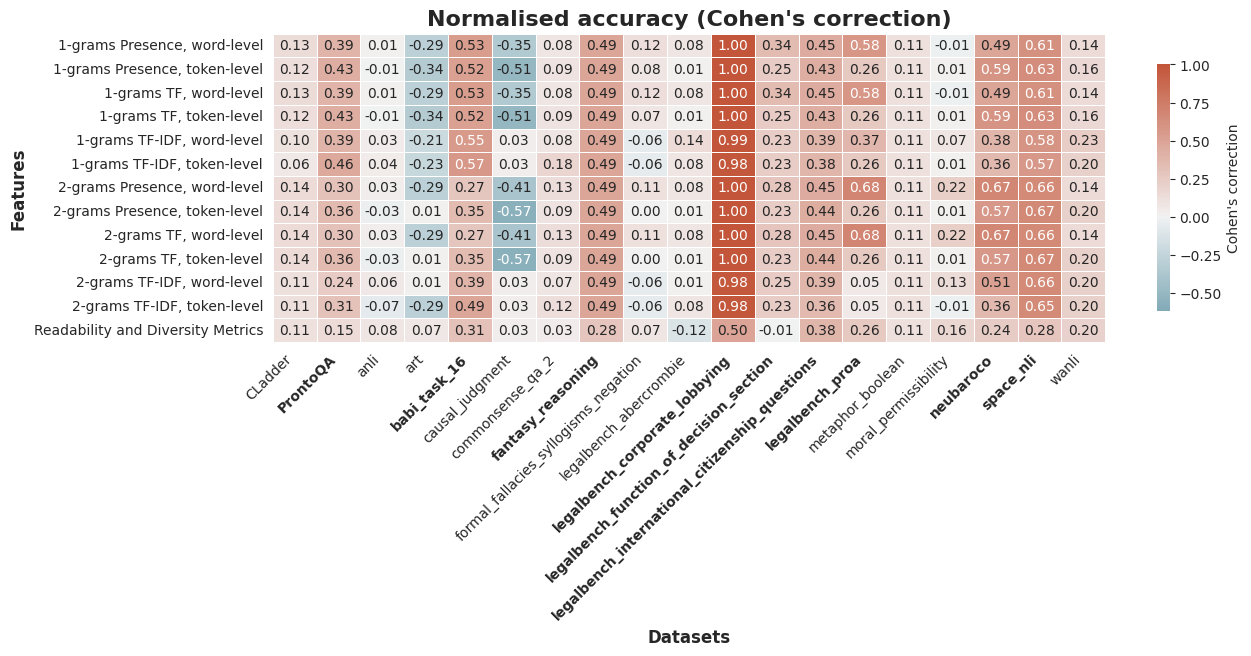

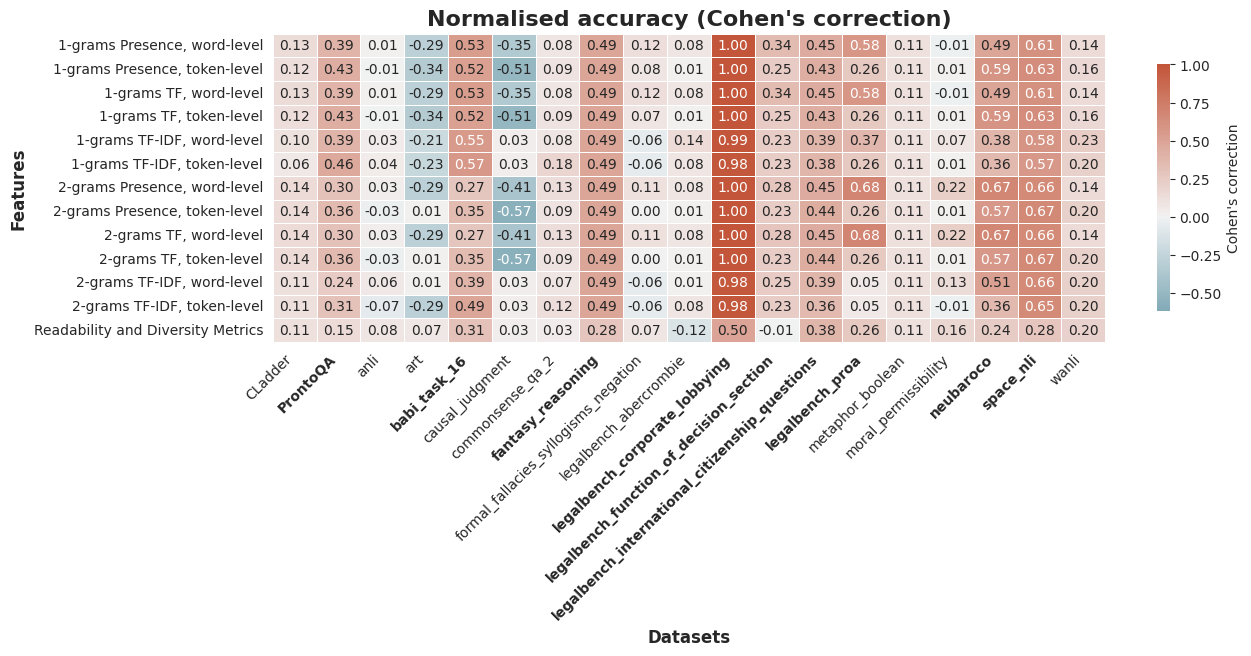

In [53]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = False

plot_heatmap(best_predictive_method_per_feature_primal_Cohen, vmin=vmin, vmax=vmax, filename="fig/ground_truth_prediction_performance_heatmap.png", title="Normalised accuracy (Cohen's correction)", cbar_label="Cohen's correction")
plot_heatmap(best_predictive_method_per_feature_primal_Cohen, vmin=vmin, vmax=vmax, filename="fig/ground_truth_prediction_performance_heatmap.pdf", title="Normalised accuracy (Cohen's correction)", cbar_label="Cohen's correction")

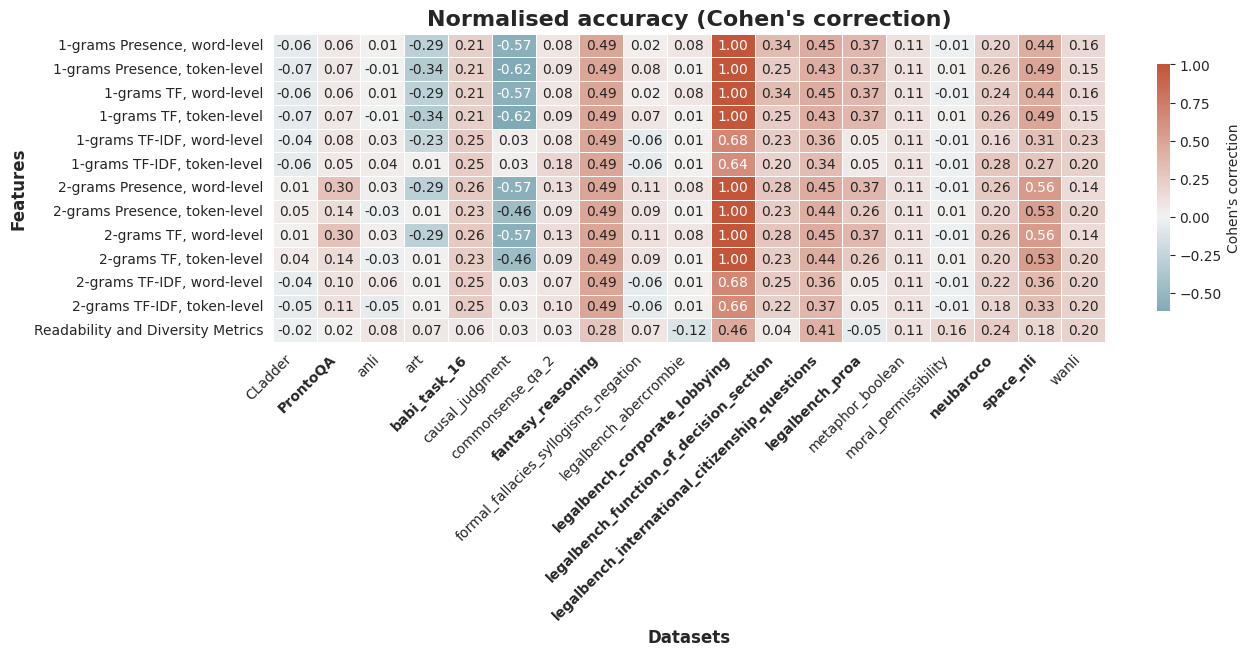

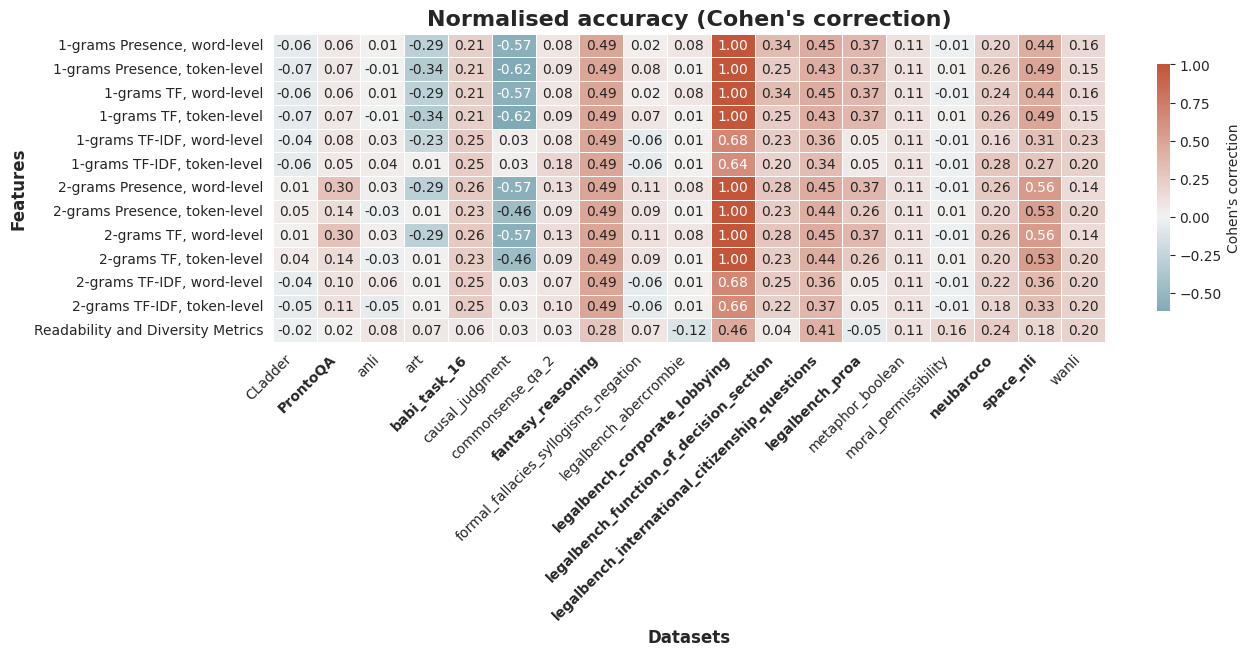

In [54]:
plot_heatmap(best_predictive_method_per_feature_primal_no_xgboost_Cohen, vmin=vmin, vmax=vmax, filename="fig/ground_truth_prediction_performance_no_xgboost_heatmap.png", title="Normalised accuracy (Cohen's correction)", cbar_label="Cohen's correction")
plot_heatmap(best_predictive_method_per_feature_primal_no_xgboost_Cohen, vmin=vmin, vmax=vmax, filename="fig/ground_truth_prediction_performance_no_xgboost_heatmap.pdf", title="Normalised accuracy (Cohen's correction)", cbar_label="Cohen's correction")

Now make barplots

In [37]:
def plot_barplot(df):
    df = df.reset_index()
    df = df.melt(id_vars="dataset", value_vars=df.columns)
    # plot the Cohen-corrected values for all features side by side
    plt.figure(figsize=(5, 5))
    sns.catplot(data=df, x='dataset', y='value',
                hue='features', kind='bar', height=5, aspect=2)
    plt.ylabel("Cohen's correction")
    # rotate x labels
    plt.xticks(rotation=90)
    # plt.title(f"{features}")
    plt.show()

<Figure size 500x500 with 0 Axes>

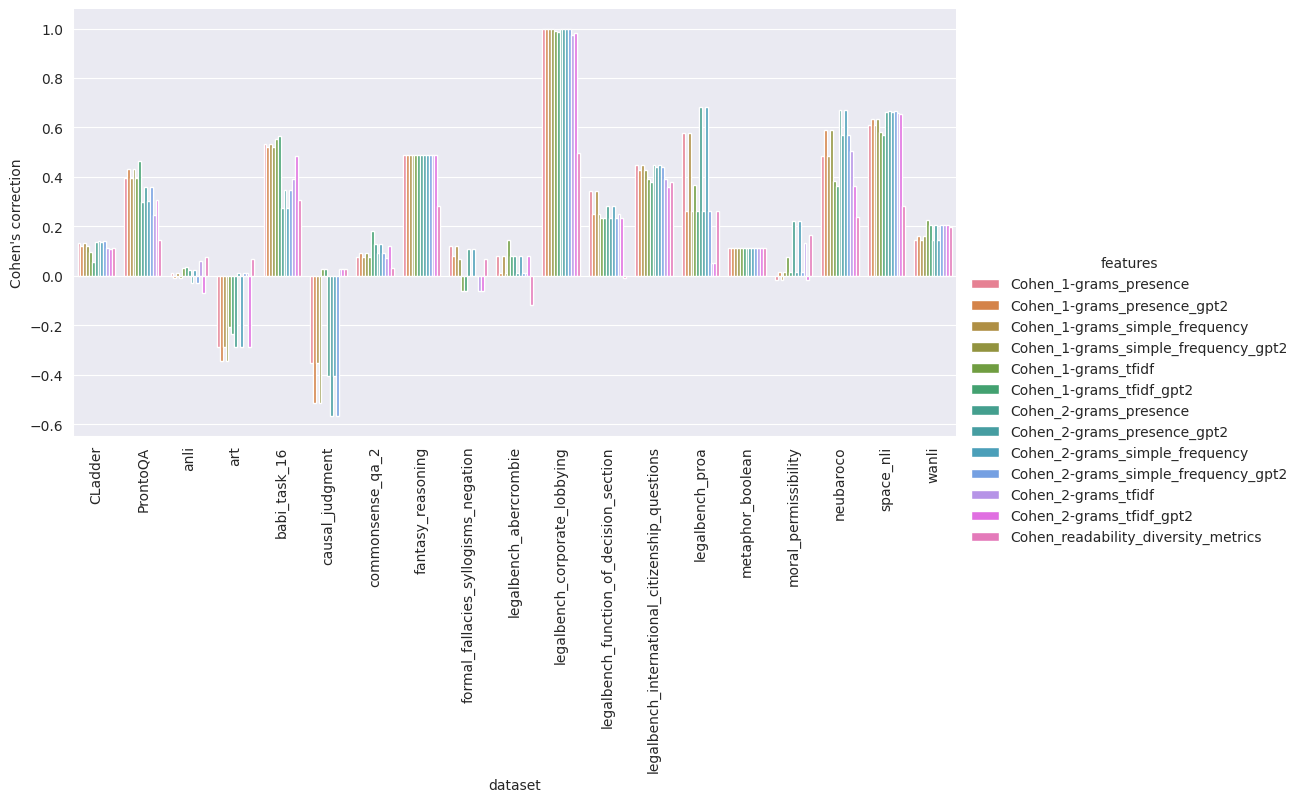

In [38]:
plot_barplot(best_predictive_method_per_feature_primal_Cohen)

<Figure size 500x500 with 0 Axes>

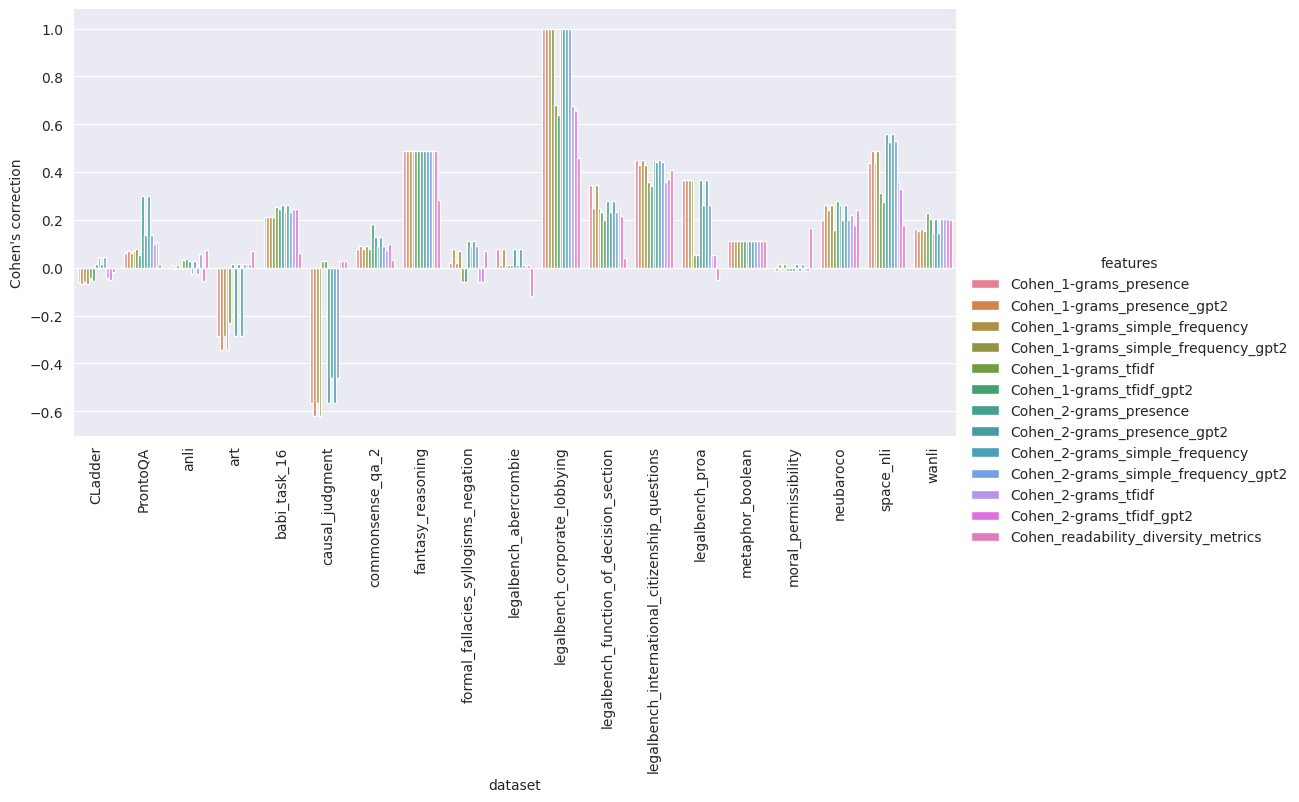

In [39]:
plot_barplot(best_predictive_method_per_feature_primal_no_xgboost_Cohen)

For most of these datasets, you have a Cohen's correction that is larger than 0, meaning that there is some predictability with simple features.